# Analysis and Visualisation
## Imports

In [ ]:
import pandas as pd
from dataframeinfo import DataFrameInfo
from datatransform import DataTransform
from plotter import Plotter

df = pd.read_csv('loan_payments_post_null_imputation.csv', index_col='id')
normalised_df = pd.read_csv('loan_payments_versions/loan_payments_transformed.csv', index_col='id')

transform = DataTransform()
query = DataFrameInfo()
visual = Plotter()

# change string to date formats.
transform.convert_string_to_date(df, 'last_payment_date')
transform.convert_string_to_date(df, 'issue_date')

transform.convert_string_to_date(normalised_df, 'last_payment_date')
transform.convert_string_to_date(normalised_df, 'issue_date')

## Current State of Loans

To understand the current state of the payments, the percentage of the loans that are recovered against the investor funding and the total amount funded is visualised.

In [ ]:
# Calculate the overall percentage of recovery against total and investor funding
total_recovery_percentage = query.calculate_column_percentage(df, 'total_payment', 'funded_amount')
total_recovery_percentage_inv = query.calculate_column_percentage(df, 'total_payment', 'funded_amount_inv')

# Visualize the results using a pie chart
categories = ['Total Funding', 'Investor Funding']
variables = [total_recovery_percentage, total_recovery_percentage_inv]
visual.pie_chart(labels=categories, sizes=variables, title='Percentage of Loans Recovered Against Funding')

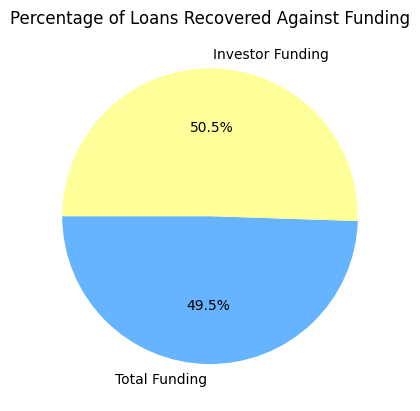

Pie chart shows that that proportion of investor funding and total funding that has been recovered is almost equal.

It was then calculated what percentage of the total amount recovered and the proportion of outstanding loan amounts that will be recovered in 6 months' time.

In [ ]:
# Working out the total amount recovered:

collection_projections = query.calculate_total_collections_over_period(df, period=6) 
total_collections = collection_projections['total_collections']
total_loan = collection_projections['total_loan']
total_loan_outstanding = collection_projections['total_loan_outstanding']

collections_percent = query.calculate_percentage(total_collections, total_loan)

# Working out the proportion of outstanding loan amounts recovered in 6 months' time.
# Variables for pie chart:
sizes_1 = [total_collections, total_loan]
sizes_2 = [total_collections, total_loan_outstanding]
# Labels for pie chart:
labels_1 = ['Collections in 6 months', 'Total loan']
labels_2 = ['Collections in 6 months', 'Total loan outstanding']
visual.two_pie_charts(sizes_1=sizes_1, labels_1=labels_1, sizes_2=sizes_2, labels_2=labels_2, plot_title='Collections over 6 months compared to loan total vs outstanding')

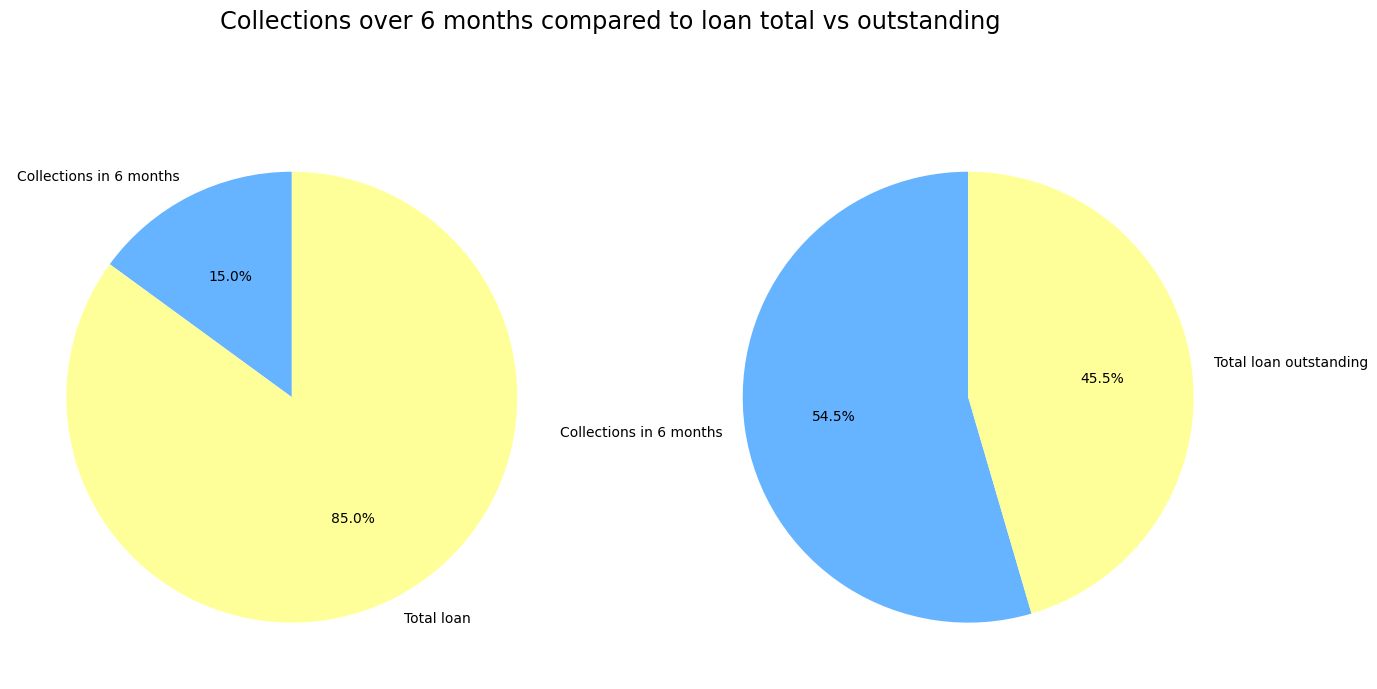

## Calculating Loss

By looking at Charged Off loans we can understand the loss to the company better.

In [ ]:
# Getting the total number and percentage of Charged Off loans
number_of_charge_offs = query.count_value_in_column(df, 'loan_status', 'Charged Off') # Total number of loans that were 'Charged Off'.
charge_off_percentage = query.calculate_percentage(number_of_charge_offs, len(df)) # Percentage of total loans that were 'Charged Off'.

# Calculating the value of Charged Off loans
funded_amounts_charged_off = df[df['loan_status']=='Charged Off']['funded_amount'].sum() 
total_payment_charged_off = df[df['loan_status']=='Charged Off']['total_payment'].sum() 
percent_paid_charged_off = query.calculate_percentage(total_payment_charged_off, funded_amounts_charged_off)

## Calculating Projected Loss

Looking at how much each revenue each Charged Off loan would have generated and how much the total projected revenue was lost. 

In [ ]:
charged_off_df = df[df['loan_status']=='Charged Off']
total_loan_amount = charged_off_df['funded_amount'] + (charged_off_df['funded_amount'] * (charged_off_df['int_rate']) * 0.01) 
charged_off_df['projected_loss'] = total_loan_amount - charged_off_df['total_payment']
projected_loss = charged_off_df['projected_loss'].sum()

# Generating bar chart to visualise loss:
categories = ['Total Expected Revenue', 'Total Actual Revenue', 'Total Loans Value', 'Charged Off Loan Paid Back Total', 'Projected Loss of Revenue']
total_expected_revenue = (df['loan_amount'] * (1 + (df['int_rate'] * 0.01))).sum()
total_actual_revenue = df['total_payment'].sum()
loans_total = df['funded_amount'].sum()
data = [total_expected_revenue/1000000000, total_actual_revenue/1000000000, loans_total/1000000000, total_payment_charged_off/1000000000, projected_loss/1000000000] # Categorical variables divided by 1,000,000,000.

visual.bar_chart(independant_categories=categories, dependant_variables=data, title="Projected Loss in Revenue from 'Charged Off' Loans", y_l)

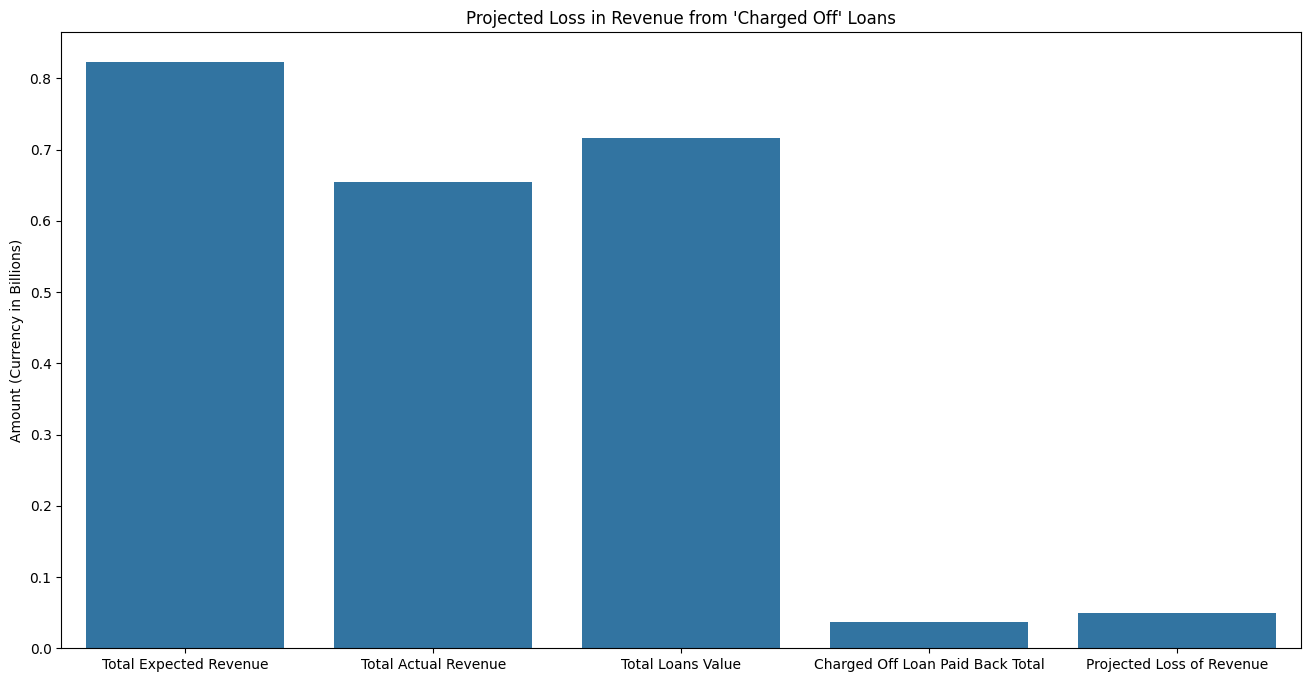

## Possible Loss

Calculating possible loss by looking at the number of Risky loans.

In [ ]:
risky_status = ['Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'] 
risky_df = df[df['loan_status'].isin(risky_status)]
current_df = df[df['loan_status'].isin(['Current','Late (31-120 days)','In Grace Period', 'Late (16-30 days)'])]

risky_customers_sum = len(risky_df)

percentage_of_risky_loans = query.calculate_percentage(risky_customers_sum, len(df))
percentage_of_current_risky_loans = query.calculate_percentage(risky_customers_sum, len(current_df))

print(f"There are {risky_customers_sum} 'Risky' loans.")

We need to consider that all risky loans have become Charged Off to calculate the total revenue that would be lost.

In [ ]:
risky_projected_revenue_lost = query.revenue_lost_by_month(risky_df) 
risky_total_revenue_lost = risky_projected_revenue_lost[-1]
risky_total_expected_revenue = query.calculate_total_expected_revenue(risky_df) 
current_total_expected_revenue = current_df['total_payment'].sum()

print(f"\nIf 'Risky' loans were 'Charged Off' the company would expect to lose {round(risky_total_revenue_lost,2)} amount of revenue.")

Visualising the percentage of total expected revenue from Risky loans if they are fully paid and as a percentage of total expected revenue from all loans:

In [ ]:
label = ['Total Projected Revenue Gained', 'Total Projected Revenue Loss']
variables_1 = [risky_total_expected_revenue-risky_total_revenue_lost, risky_total_revenue_lost]
variables_2 = [current_total_expected_revenue-risky_total_revenue_lost, risky_total_revenue_lost]
title = 'Potential Revenue Lost from Risky Loans'
title_1 = 'Projected Revenue Lost from Risky Loans'
title_2 = "Projected Revenue Lost from Total Current Loans' Expected Revenue"

visual.two_pie_charts(labels_1=label, sizes_1=variables_1, labels_2=label, sizes_2=variables_2, title_1=title_1, title_2=title_2, plot_title=title)

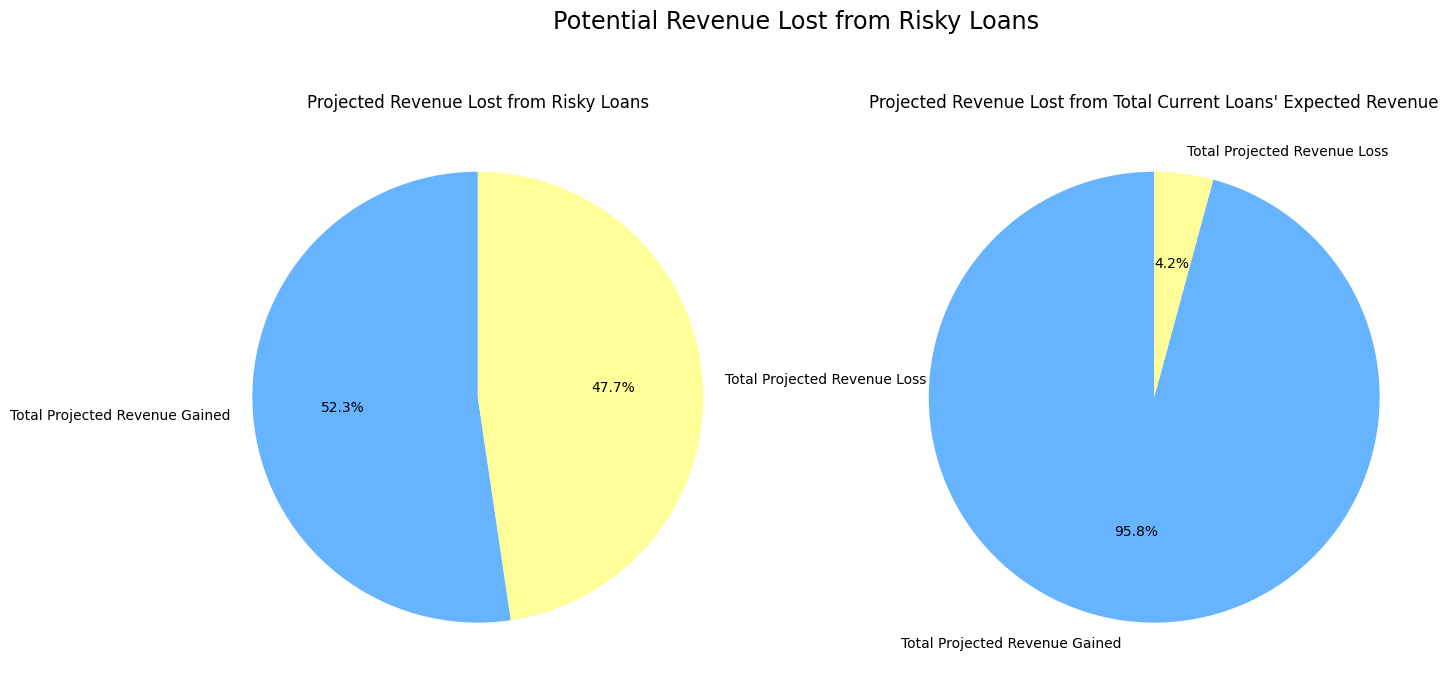

## Indicators of Loss

The following variables were identified as potential  factors which could influence the risk of loss for a loan:

- term
- grade
- employment_length
- home_ownership
- purpose

 The variables have been be compared between subsets of the loan customers (all loans; fully paid loans; charged off and defaulted loans; risky loans) to see if there are any patterns amongst customers who are behind on payments.
 
 Below shows how the **term** length of the loan may have an impact on the risk of loss:

In [ ]:
visual.discrete_value_risk_comparison(df, 'term')

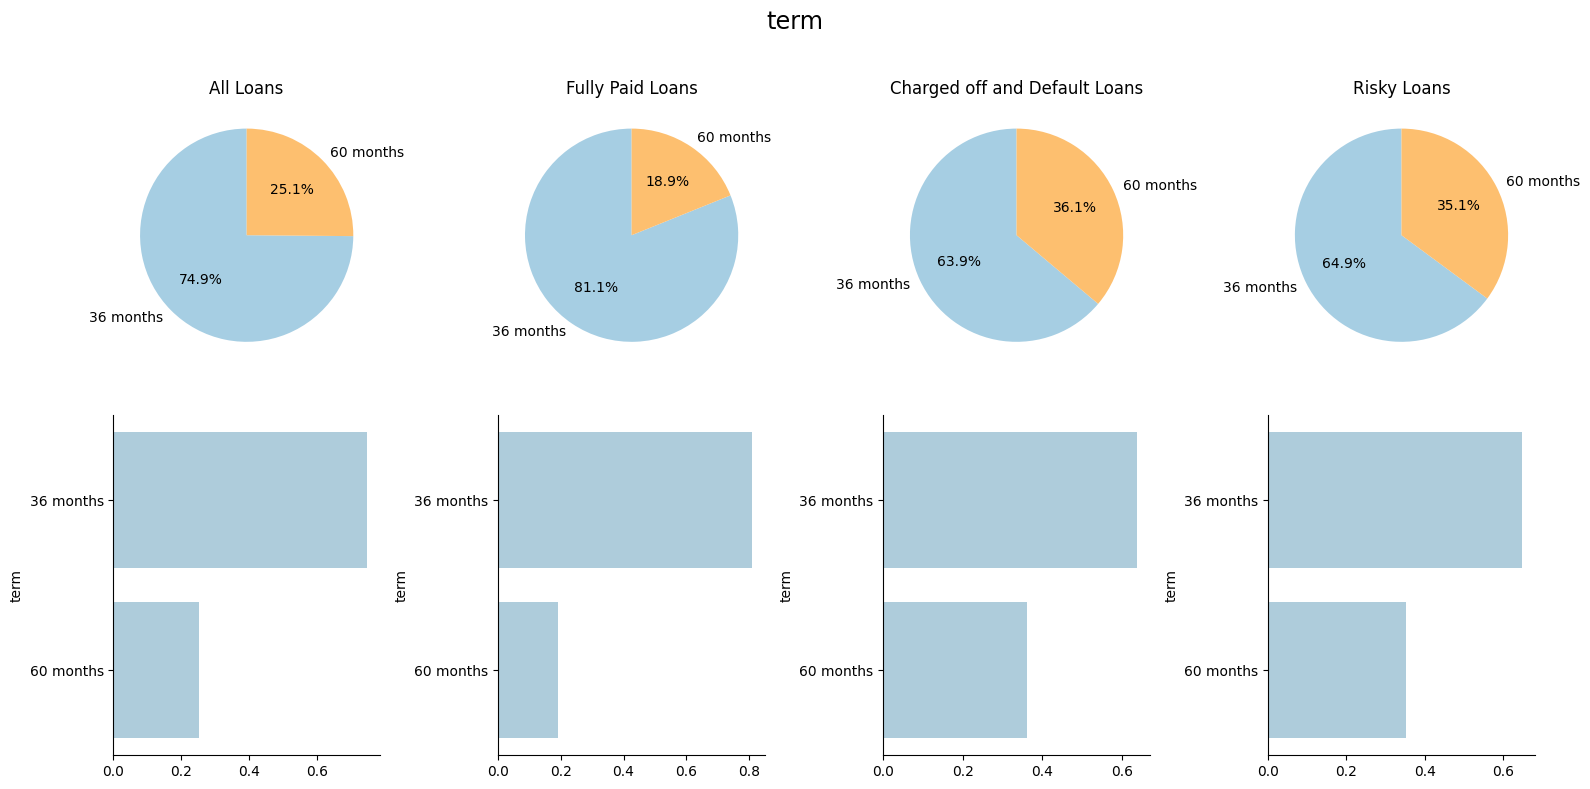

The graphs show that whilst '36 month' terms are most common, '60 month' terms have a significantly higher chance of becoming a risky or unsucceful loan.

The following visualisation shows the impact **grade** ratings have on risk of loss:

In [ ]:
visual.discrete_value_risk_comparison(df, 'grade')

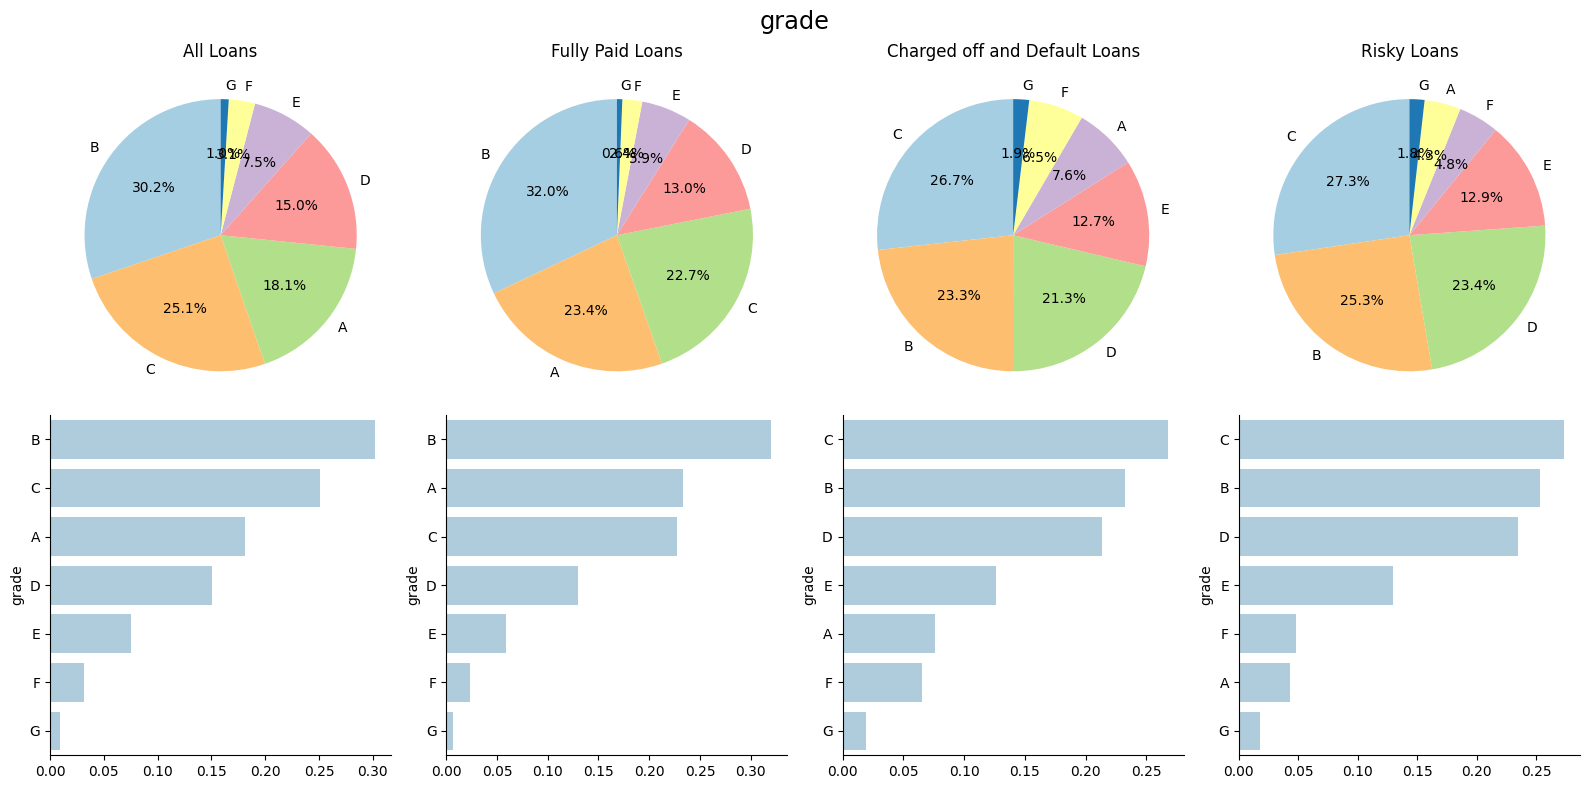

Shows that grade 'B' is the most common in the average and fully paid off loan whilst grade 'C' is most common in riskier and unsucceful loans, along with higher rates of grade 'D' and 'E'.

Below is shown how home ownership impacts risk of loss:

In [ ]:
visual.discrete_value_risk_comparison(df, 'home_ownership')

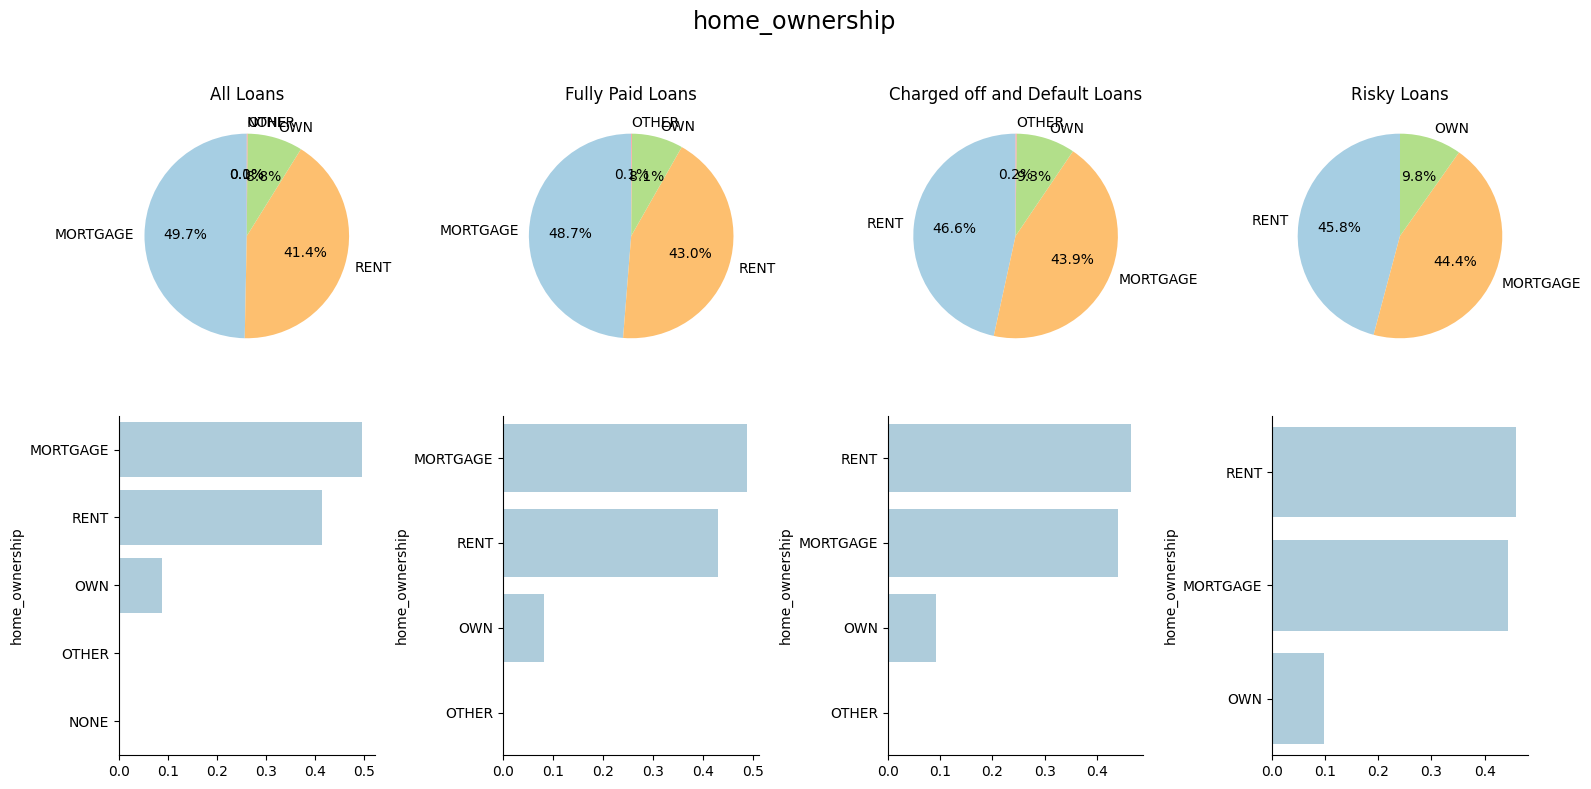

Shows that succesfully paid loans are more likely to be from people with mortgages whilst unsuccesful and risky loans are more likely to be from customers that rent.

The next visualisation shows the impact of the purpose of the loan on risk of loss:

In [ ]:
visual.discrete_value_risk_comparison(df, 'purpose')

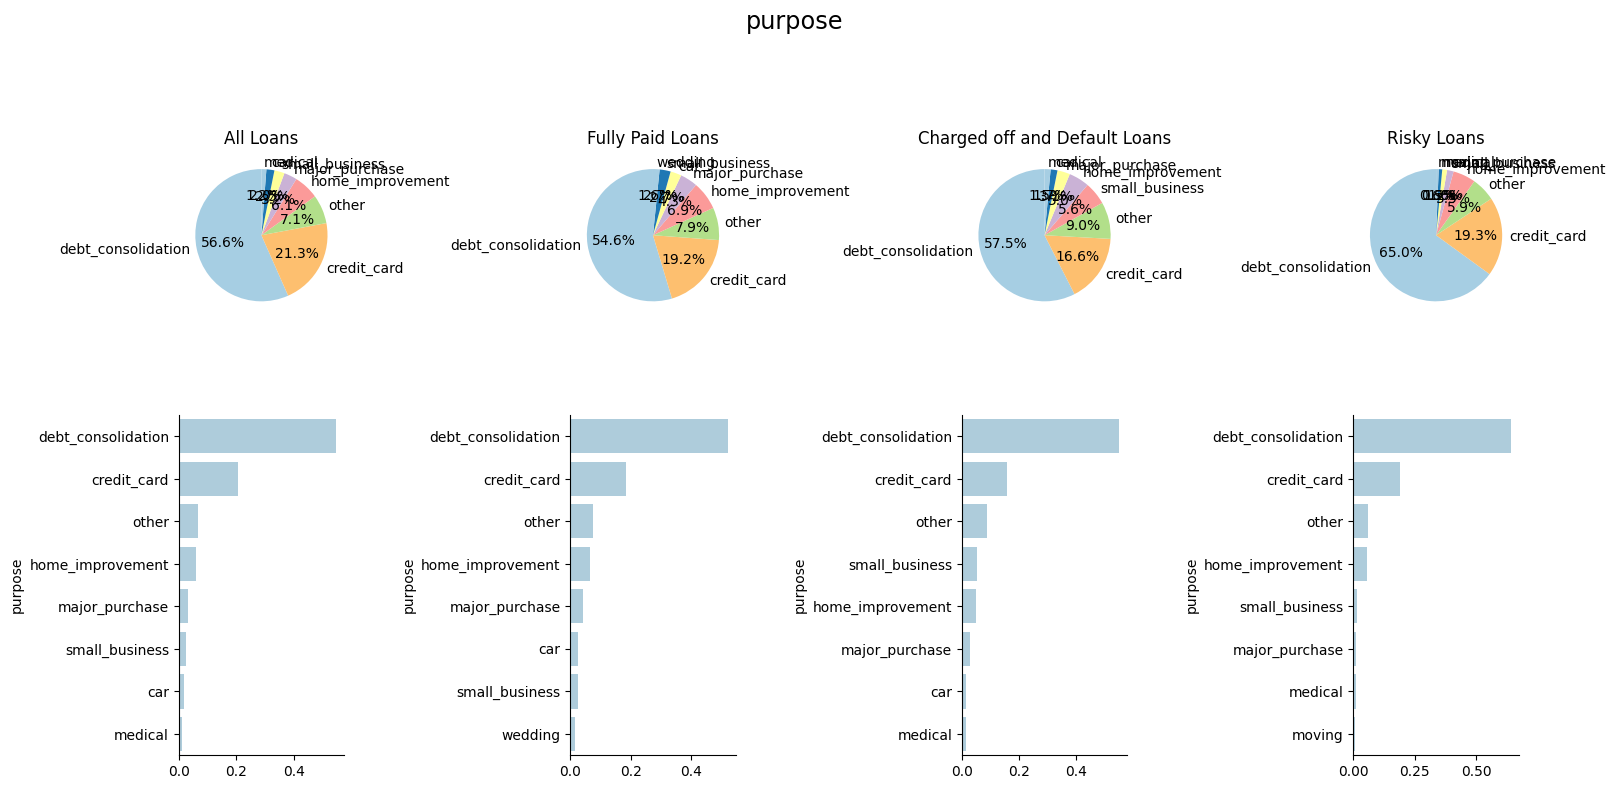

Shows that debt consolidation is the majority purpose for all loans and is also significantly more likely to be a loan which is risky. Small business loans also seem to be slightly more likely to be charged off or defaulted.